In [9]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
from cil.optimisation.functions import ZeroFunction, MixedL21Norm, L2NormSquared, BlockFunction, TotalVariation
from cil.optimisation.operators import GradientOperator, BlockOperator,IdentityOperator, SymmetrisedGradientOperator, ZeroOperator
from cil.optimisation.algorithms import PDHG
from cil.utilities import dataexample
from cil.utilities import noise

from skimage.metrics import structural_similarity as ssim

from cil.utilities.display import show2D


In [2]:
# Load an image from the CIL gallery. 
data = dataexample.SHAPES.get()
ig = data.geometry   

In [3]:
# Add gaussian noise
noisy_data = noise.gaussian(data, seed = 10, var = 0.01)

In [4]:
# Regularisation parameters
alpha_tgv = 0.12
beta = 2*alpha_tgv

In [5]:
K11 = GradientOperator(ig)
K12 = IdentityOperator(K11.range)
K22 = SymmetrisedGradientOperator(K11.range)    
K21 = ZeroOperator(ig, K22.range)    

K = BlockOperator(K11, -K12, K21, K22, shape=(2,2) )   

f1 = alpha_tgv * MixedL21Norm()
f2 = beta * MixedL21Norm() 
f3 = 0.5 * L2NormSquared(b=noisy_data)

F = BlockFunction(f1, f2)         
G = BlockFunction(f3, ZeroFunction())

# Compute operator Norm
normK = K.norm()

# Primal & dual stepsizes
sigma = 1./normK
tau = 1./normK

# Setup and run the PDHG algorithm
pdhg = PDHG(f=F,g=G,operator=K, tau=tau, sigma=sigma,
            max_iteration = 2000,
            update_objective_interval = 500)
pdhg.run(2000, verbose=2)


Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       2000         0.000    1.03594e+04  -0.00000e+00    1.03594e+04


/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      500       2000         0.015    3.45437e+02   3.40359e+02    5.07736e+00
     1000       2000         0.015    3.44196e+02   3.41951e+02    2.24543e+00
     1500       2000         0.015    3.43778e+02   3.42453e+02    1.32542e+00
     2000       2000         0.015    3.43588e+02   3.42680e+02    9.07982e-01
----------------------------------------------------------------------------
     2000       2000         0.015    3.43588e+02   3.42680e+02    9.07982e-01
Stop criterion has been reached.



In [6]:
val_ssim_tgv = ssim(data.as_array(), pdhg.solution.get_item(0).as_array(), data_range = 1.)

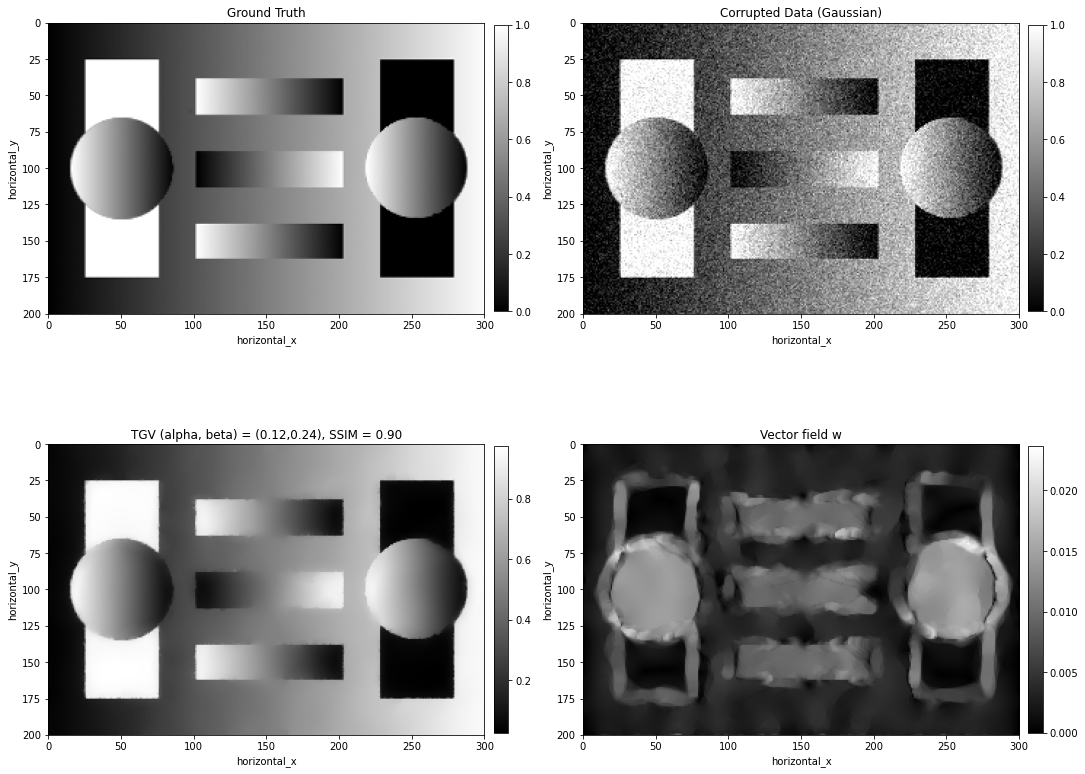

In [7]:
show2D([data, noisy_data, pdhg.solution.get_item(0), pdhg.solution.get_item(1).pnorm(2)],
          title=["Ground Truth", 
                  "Corrupted Data (Gaussian)", 
                  "TGV (alpha, beta) = ({},{}), SSIM = {:.2f}".format(alpha_tgv, beta, val_ssim_tgv),
                  "Vector field w"],
         origin = "upper")

In [10]:
# Compare with Total Variation denoising
alpha_tv = 0.1
TV = alpha_tv * TotalVariation(max_iteration=500)

# Run proximal operator for the TotalVariation
proxTV = TV.proximal(noisy_data, tau=1.0)
val_ssim_tv = ssim(data.as_array(), proxTV.as_array(), data_range = 1.)

Initialised GradientOperator with C backend running with  20  threads


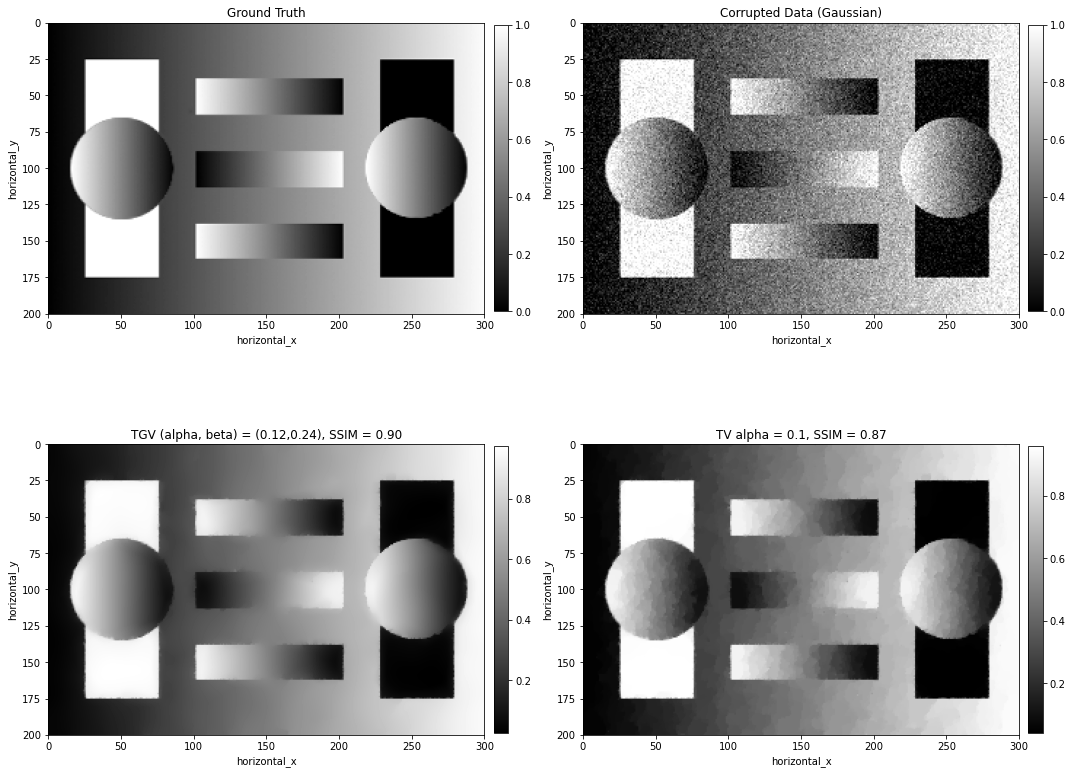

In [11]:
show2D([data, noisy_data, pdhg.solution.get_item(0), proxTV],
          title=["Ground Truth", 
                  "Corrupted Data (Gaussian)", 
                  "TGV (alpha, beta) = ({},{}), SSIM = {:.2f}".format(alpha_tgv, beta, val_ssim_tgv),
                  "TV alpha = {}, SSIM = {:.2f}".format(alpha_tv, val_ssim_tv)],
         origin = "upper")

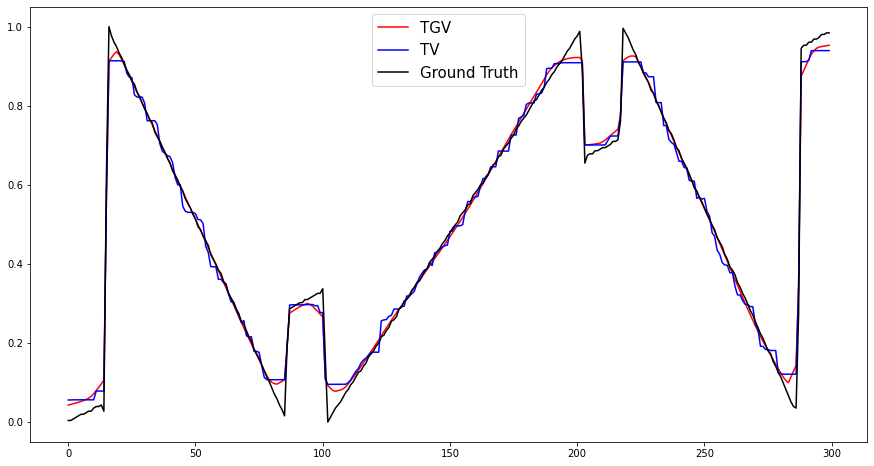

In [12]:
plt.figure(figsize=(15,8))
plt.plot(pdhg.solution.get_item(0).as_array()[100], color="red",linestyle='solid', label = "TGV")
plt.plot(proxTV.as_array()[100], color="blue",linestyle='solid', label = "TV")
plt.plot(data.as_array()[100], color="black", linestyle='solid', label = "Ground Truth")
plt.legend(fontsize=15, loc="upper center")
plt.show()